In [1]:
import numpy as np 
from scipy.stats import norm

In [2]:
# Equations
beta_dist = norm(-3, 0.2)
gamma_dist = norm(10, 0.1)
delta_dist = norm(10, 0.1)
epsilon_dist = norm(5, 0.2)
sigma_a_dist = norm(0, 0.3)
sigma_b_dist = norm(0, 0.2)


def a_equation(b, c):
    return beta_dist.rvs() * b + gamma_dist.rvs() * c + sigma_a_dist.rvs()

def b_equation(d, e):
    return delta_dist.rvs() * d + epsilon_dist.rvs() * e + sigma_b_dist.rvs()

In [3]:
cc = norm().rvs(1000)
dd = norm(-10, 1).rvs(1000)
ee = norm(10, 1).rvs(1000)

bb = b_equation(dd, ee)
aa = a_equation(bb, cc)

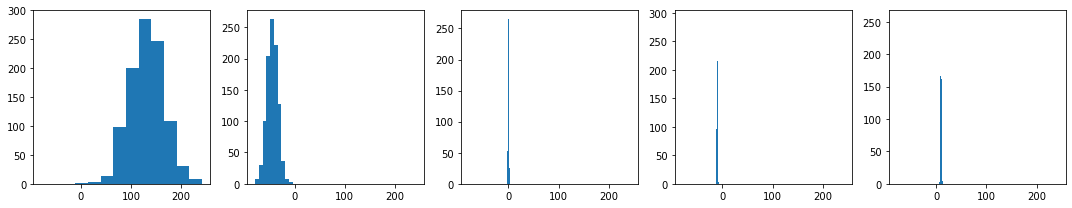

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(15, 3), ncols=5, sharex=True)

for var, ax in zip([aa, bb, cc, dd, ee], axes.flatten()):
    ax.hist(var)

plt.tight_layout()

In [5]:
import pymc as pm

In [7]:
import pandas as pd 

data = pd.DataFrame({"a": aa, "b": bb, "c": cc, "d": dd, "e": ee})
data

,a,b,c,d,e
0,117.512830,-39.355058,-0.025221,-10.206377,11.109425
1,111.737827,-40.367278,-0.902227,-10.197426,10.909012
2,120.901201,-36.312917,1.219412,-9.024237,9.546910
3,148.638055,-50.396974,-0.218008,-11.012214,10.540914
4,134.767782,-43.926680,0.330027,-10.473192,10.754401
...,...,...,...,...,...
995,177.902284,-56.764369,0.797804,-10.710860,8.841440
996,131.120462,-40.719778,0.923072,-9.326139,9.284723
997,175.586983,-58.547678,0.035428,-11.476544,9.887584
998,79.349310,-28.562353,-0.607729,-9.683840,12.139800


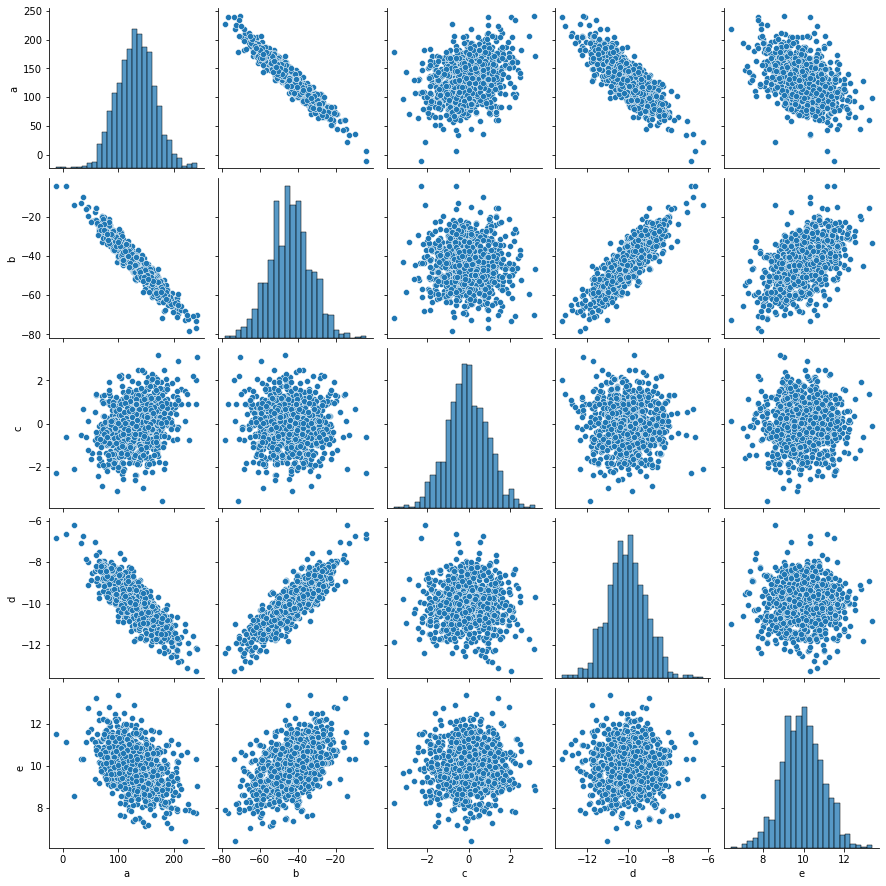

In [9]:
import seaborn as sns 

sns.pairplot(data)

## Bayesian inference

In [48]:

with pm.Model() as model_a:
    a = pm.Data("a", data["a"])
    b = pm.Data("b", data["b"])
    c = pm.Data("c", data["c"])
    # Priors for model parameters
    beta = pm.Normal("beta", mu=0, sigma=3)
    gamma = pm.Normal("gamma", mu=0, sigma=3)
    sigma_a = pm.HalfCauchy("sigma_a", beta=1)
    pm.Normal("like", mu=beta * b + gamma * c, sigma=sigma_a, observed=a)


with pm.Model() as model_b:
    b = pm.Data("b", data["b"])
    d = pm.Data("d", data["d"])
    e = pm.Data("e", data["e"])
    delta = pm.Normal("delta", mu=0, sigma=3)
    epsilon = pm.Normal("epsilon", mu=0, sigma=3)
    sigma_b = pm.HalfCauchy("sigma_b", beta=1)
    pm.Normal("like", mu=delta * d + epsilon * e, sigma=sigma_b, observed=b)


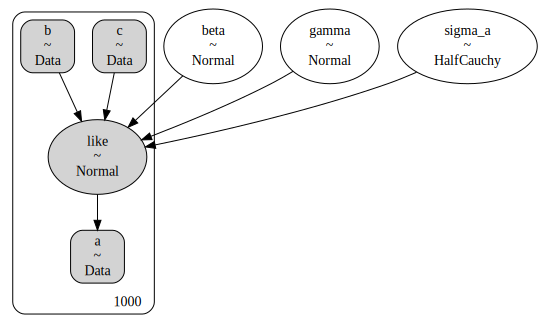

In [49]:
pm.model_to_graphviz(model_a)

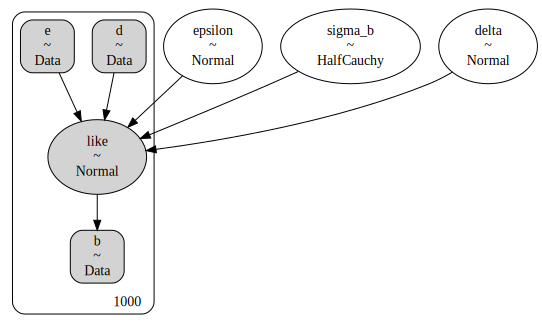

In [50]:
pm.model_to_graphviz(model_b)

In [52]:
with model_a:
    idata_a = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, gamma, sigma_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8799, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.93, but should be close to 0.8. Try to increase the number of tuning steps.


In [53]:

with model_b:
    idata_b = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [delta, epsilon, sigma_b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.9122, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915, but should be close to 0.8. Try to increase the number of tuning steps.


array([<AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'gamma'}>,
       <AxesSubplot:title={'center':'sigma_a'}>], dtype=object)

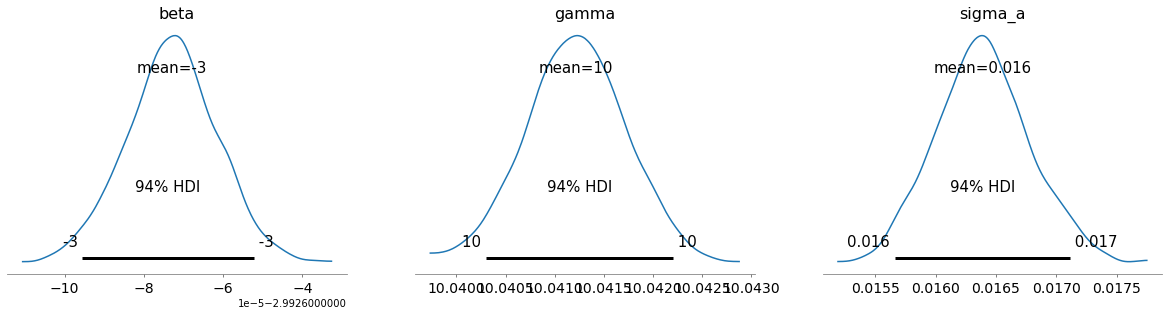

In [54]:
import arviz as az

az.plot_posterior(idata_a)

array([<AxesSubplot:title={'center':'delta'}>,
       <AxesSubplot:title={'center':'epsilon'}>,
       <AxesSubplot:title={'center':'sigma_b'}>], dtype=object)

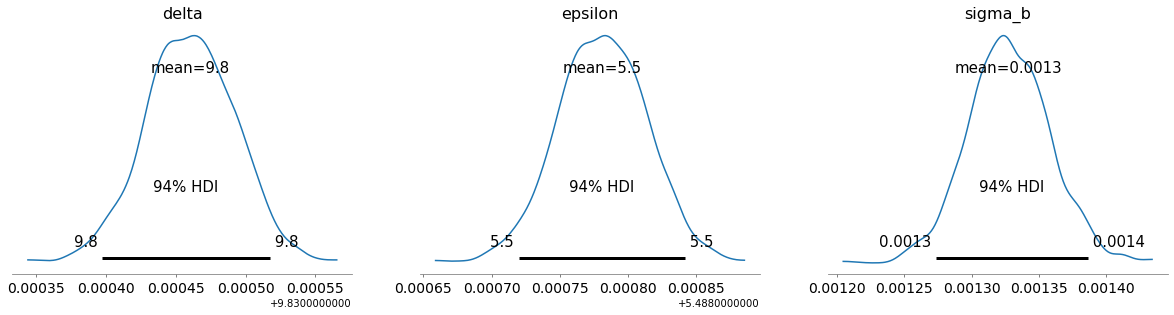

In [55]:
az.plot_posterior(idata_b)

## Do-Operator: personalized counterfactual

In [57]:
sample = data.sample(random_state=491)
sample["a"].values

array([101.11101073])

In [65]:
import numpy as np 


with model_a:
    pm.set_data({"a": sample["a"], "b": sample["b"], "c": sample["c"]})
    ppc_or = pm.sample_posterior_predictive(idata_a)

    # cf = "counterfactual"
    pm.set_data({"a": sample["a"], "b": np.array([-20]), "c": sample["c"]})
    ppc_cf = pm.sample_posterior_predictive(idata_a)



<AxesSubplot:title={'center':'like\n0'}>

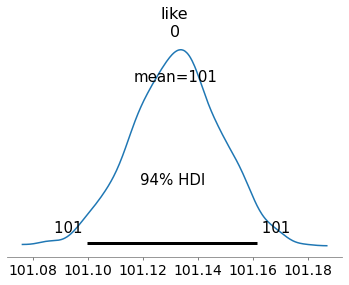

In [70]:
az.plot_posterior(ppc_or.posterior_predictive["like"])

<AxesSubplot:title={'center':'like\n0'}>

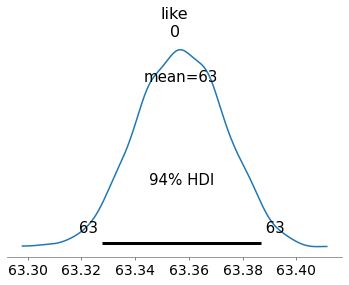

In [71]:
az.plot_posterior(ppc_cf.posterior_predictive["like"])

That's really cool, we have now a range of probable outcomes because we used probabilistic programming in conjunction with causal thinking!